In [1]:
!pip -q install -U "transformers>=4.39,<5.0" "datasets>=2.19,<3.0" "peft>=0.11,<0.12" "accelerate>=0.29,<1.0" tqdm scikit-learn

import torch, sys, transformers, datasets, peft
print("Python:", sys.version)
print("Torch:", torch.__version__, "| CUDA:", torch.cuda.is_available())
print("Transformers:", transformers.__version__)
print("Datasets:", datasets.__version__)
print("PEFT:", peft.__version__)


Python: 3.12.11 (main, Jun  4 2025, 08:56:18) [GCC 11.4.0]
Torch: 2.8.0+cu126 | CUDA: True
Transformers: 4.56.1
Datasets: 2.21.0
PEFT: 0.11.1


In [2]:
import random, numpy as np

MODEL_NAME   = "distilbert-base-uncased"
OUT_ADAPTER  = "/content/toxic_lora"      # final LoRA adapter folder
MAX_LEN      = 256
LABELS       = ["toxic","severe_toxic","obscene","threat","insult","identity_hate"]
NUM_LABELS   = len(LABELS)
SEED         = 42

def set_seed(seed=SEED):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
set_seed()


In [3]:
from datasets import load_dataset

# Load ONLY the labeled file to avoid the unlabeled test.csv
ds_train_only = load_dataset(
    "thesofakillers/jigsaw-toxic-comment-classification-challenge",
    data_files={"train": "train.csv"},
    split="train",
)

# Make a small validation split from train
ds_split = ds_train_only.train_test_split(test_size=0.05, seed=SEED)
train_raw, valid_raw = ds_split["train"], ds_split["test"]

print(train_raw[:2])
print("Train/Valid sizes:", len(train_raw), len(valid_raw))
print("Columns:", train_raw.column_names)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


{'id': ['f38bbddbee5a6ebb', '9936e94196a54d88'], 'comment_text': ["That's right. What's your concern?", 'I agree.  (I know I am Pro)'], 'toxic': [0, 0], 'severe_toxic': [0, 0], 'obscene': [0, 0], 'threat': [0, 0], 'insult': [0, 0], 'identity_hate': [0, 0]}
Train/Valid sizes: 151592 7979
Columns: ['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']


In [4]:
from transformers import AutoConfig, AutoModelForSequenceClassification
from peft import LoraConfig, get_peft_model, TaskType

config = AutoConfig.from_pretrained(
    MODEL_NAME,
    num_labels=NUM_LABELS,
    id2label={i: L for i, L in enumerate(LABELS)},
    label2id={L: i for i, L in enumerate(LABELS)},
    problem_type="multi_label_classification",
)

base = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, config=config)

# DistilBERT attention modules are q_lin/k_lin/v_lin/out_lin
lora_cfg = LoraConfig(
    r=8, lora_alpha=16, lora_dropout=0.05,
    bias="none", task_type=TaskType.SEQ_CLS,
    target_modules=["q_lin","k_lin","v_lin","out_lin"]
)

model = get_peft_model(base, lora_cfg)
model.print_trainable_parameters()


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 890,118 || all params: 67,848,204 || trainable%: 1.3119


In [5]:
from transformers import AutoTokenizer
tok = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)

def prep(ex):
    text = (ex.get("comment_text") or "").strip()
    enc  = tok(text, truncation=True, max_length=MAX_LEN)
    enc["labels"] = [float(ex.get(k, 0.0)) for k in LABELS]  # float multi-label vector
    return enc

train_ds = train_raw.map(prep, remove_columns=train_raw.column_names)
valid_ds = valid_raw.map(prep, remove_columns=valid_raw.column_names)

train_ds.set_format(type="torch")
valid_ds.set_format(type="torch")

print(train_ds[0].keys())


Map:   0%|          | 0/7979 [00:00<?, ? examples/s]

dict_keys(['input_ids', 'attention_mask', 'labels'])


In [8]:
# Make accelerate compatible with transformers calling unwrap_model(..., keep_torch_compile=...)
!pip -q install -U "accelerate>=0.34.2,<1.0"

import inspect
import accelerate
from accelerate import Accelerator

print("accelerate:", accelerate.__version__)

# If this accelerate doesn't accept keep_torch_compile, shim it out:
if "keep_torch_compile" not in inspect.signature(Accelerator.unwrap_model).parameters:
    _orig_unwrap = Accelerator.unwrap_model
    def _unwrap_model_compat(self, model, *args, **kwargs):
        kwargs.pop("keep_torch_compile", None)
        return _orig_unwrap(self, model, *args, **kwargs)
    Accelerator.unwrap_model = _unwrap_model_compat
    print("Patched Accelerator.unwrap_model for compatibility ✅")
else:
    print("unwrap_model has keep_torch_compile already ✅")


accelerate: 0.34.2
Patched Accelerator.unwrap_model for compatibility ✅


In [12]:
# Cell 6A — Build DataLoaders (no Trainer)
import torch
from torch.utils.data import DataLoader
from transformers import DataCollatorWithPadding

BATCH_TRAIN = 16
BATCH_VALID = 32

collator = DataCollatorWithPadding(tok)
train_dl = DataLoader(train_ds, batch_size=BATCH_TRAIN, shuffle=True, collate_fn=collator)
valid_dl = DataLoader(valid_ds, batch_size=BATCH_VALID, shuffle=False, collate_fn=collator)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): DistilBertForSequenceClassification(
      (distilbert): DistilBertModel(
        (embeddings): Embeddings(
          (word_embeddings): Embedding(30522, 768, padding_idx=0)
          (position_embeddings): Embedding(512, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (transformer): Transformer(
          (layer): ModuleList(
            (0-5): 6 x TransformerBlock(
              (attention): DistilBertSdpaAttention(
                (dropout): Dropout(p=0.1, inplace=False)
                (q_lin): lora.Linear(
                  (base_layer): Linear(in_features=768, out_features=768, bias=True)
                  (lora_dropout): ModuleDict(
                    (default): Dropout(p=0.05, inplace=False)
                  )
                  (lora_A): ModuleDict(
                    (default): Linear(in_features=7

In [13]:
# Cell 6B — Pure PyTorch training loop + eval
import math, numpy as np
from tqdm.auto import tqdm
from torch.optim import AdamW
from torch.nn import BCEWithLogitsLoss
from transformers import get_linear_schedule_with_warmup

EPOCHS = 2
lr = 2e-5
weight_decay = 0.01
max_grad_norm = 1.0

# Optimizer + scheduler
opt = AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
total_steps = EPOCHS * len(train_dl)
sched = get_linear_schedule_with_warmup(opt, num_warmup_steps=int(0.06*total_steps), num_training_steps=total_steps)

bce = BCEWithLogitsLoss()

def evaluate():
    model.eval()
    all_logits = []
    all_labels = []
    with torch.no_grad():
        for batch in tqdm(valid_dl, desc="eval", leave=False):
            labels = batch.pop("labels").to(device).to(torch.float32)
            for k in list(batch.keys()):
                batch[k] = batch[k].to(device)
            logits = model(**batch).logits
            all_logits.append(logits.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
    logits = np.concatenate(all_logits, axis=0)
    labels = np.concatenate(all_labels, axis=0)
    probs  = 1.0 / (1.0 + np.exp(-logits))         # sigmoid
    preds  = (probs >= 0.5).astype(np.int32)
    labels = labels.astype(np.int32)
    tp = (preds & labels).sum()
    fp = (preds & (1 - labels)).sum()
    fn = ((1 - preds) & labels).sum()
    micro_f1 = (2*tp) / (2*tp + fp + fn + 1e-9)
    return float(micro_f1)

best_f1 = -1.0
for epoch in range(1, EPOCHS+1):
    model.train()
    running = 0.0
    pbar = tqdm(train_dl, desc=f"epoch {epoch}/{EPOCHS}")
    for batch in pbar:
        labels = batch.pop("labels").to(device).to(torch.float32)
        for k in list(batch.keys()):
            batch[k] = batch[k].to(device)

        opt.zero_grad(set_to_none=True)
        out = model(**batch)
        loss = bce(out.logits, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        opt.step()
        sched.step()

        running += loss.item()
        pbar.set_postfix(loss=f"{running / (pbar.n or 1):.4f}")

    # eval after each epoch
    f1 = evaluate()
    print(f"\nEpoch {epoch}: micro-F1 = {f1:.4f}")
    best_f1 = max(best_f1, f1)

print(f"\nBest micro-F1: {best_f1:.4f}")


epoch 1/2:   0%|          | 0/9475 [00:00<?, ?it/s]

eval:   0%|          | 0/250 [00:00<?, ?it/s]


Epoch 1: micro-F1 = 0.7556


epoch 2/2:   0%|          | 0/9475 [00:00<?, ?it/s]

eval:   0%|          | 0/250 [00:00<?, ?it/s]


Epoch 2: micro-F1 = 0.7658

Best micro-F1: 0.7658


In [14]:
# LoRA sanity: how many params are trainable?
model.print_trainable_parameters()

# Optional: list trainable tensors (should see lora_A/lora_B and classifier)
for n, p in model.named_parameters():
    if p.requires_grad:
        print(n)


trainable params: 890,118 || all params: 67,848,204 || trainable%: 1.3119
base_model.model.distilbert.transformer.layer.0.attention.q_lin.lora_A.default.weight
base_model.model.distilbert.transformer.layer.0.attention.q_lin.lora_B.default.weight
base_model.model.distilbert.transformer.layer.0.attention.k_lin.lora_A.default.weight
base_model.model.distilbert.transformer.layer.0.attention.k_lin.lora_B.default.weight
base_model.model.distilbert.transformer.layer.0.attention.v_lin.lora_A.default.weight
base_model.model.distilbert.transformer.layer.0.attention.v_lin.lora_B.default.weight
base_model.model.distilbert.transformer.layer.0.attention.out_lin.lora_A.default.weight
base_model.model.distilbert.transformer.layer.0.attention.out_lin.lora_B.default.weight
base_model.model.distilbert.transformer.layer.1.attention.q_lin.lora_A.default.weight
base_model.model.distilbert.transformer.layer.1.attention.q_lin.lora_B.default.weight
base_model.model.distilbert.transformer.layer.1.attention.k_li

In [15]:
from sklearn.metrics import precision_recall_curve
import numpy as np, torch, json, os

def collect_logits_labels(dl):
    model.eval()
    all_logits, all_labels = [], []
    with torch.no_grad():
        for batch in dl:
            labels = batch["labels"].numpy()
            b = {k: v.to(device) for k, v in batch.items() if k != "labels"}
            logits = model(**b).logits.cpu().numpy()
            all_logits.append(logits); all_labels.append(labels)
    return np.concatenate(all_logits), np.concatenate(all_labels)

logits, labels = collect_logits_labels(valid_dl)
probs = 1/(1+np.exp(-logits))

thr = {}
per_label = {}
for i, lab in enumerate(LABELS):
    prec, rec, t = precision_recall_curve(labels[:, i], probs[:, i])
    f1 = (2*prec*rec) / (prec+rec+1e-9)
    j = f1.argmax()
    # precision_recall_curve returns t with length-1 vs prec/rec; guard index
    chosen_t = float(t[j-1]) if j > 0 and (j-1) < len(t) else 0.5
    thr[lab] = round(chosen_t, 3)
    per_label[lab] = {"best_f1": float(f1[j]), "precision": float(prec[j]), "recall": float(rec[j])}

print("Thresholds:", thr)
print("Per-label:", per_label)
# save them with the adapter for your agent
OUT_ADAPTER = "/content/toxic_lora"
os.makedirs(OUT_ADAPTER, exist_ok=True)
with open(f"{OUT_ADAPTER}/thresholds.json","w") as f: json.dump({"thresholds": thr}, f)


Thresholds: {'toxic': 0.395, 'severe_toxic': 0.275, 'obscene': 0.448, 'threat': 0.068, 'insult': 0.451, 'identity_hate': 0.166}
Per-label: {'toxic': {'best_f1': 0.8148614604575287, 'precision': 0.7938650306748466, 'recall': 0.8369987063389392}, 'severe_toxic': {'best_f1': 0.5299999995288, 'precision': 0.4274193548387097, 'recall': 0.6973684210526315}, 'obscene': {'best_f1': 0.826966291635036, 'precision': 0.8105726872246696, 'recall': 0.8440366972477065}, 'threat': {'best_f1': 0.2264150939337843, 'precision': 0.15789473684210525, 'recall': 0.4}, 'insult': {'best_f1': 0.7599067594083248, 'precision': 0.7196467991169978, 'recall': 0.8049382716049382}, 'identity_hate': {'best_f1': 0.3832335324536556, 'precision': 0.32, 'recall': 0.47761194029850745}}


In [16]:
import os, json, shutil

OUT_ADAPTER = "/content/toxic_lora"
os.makedirs(OUT_ADAPTER, exist_ok=True)

model.save_pretrained(OUT_ADAPTER)        # LoRA adapter only
tok.save_pretrained(OUT_ADAPTER)

with open(f"{OUT_ADAPTER}/labels.json","w") as f:
    json.dump({"labels": LABELS}, f)

# (thresholds.json already written if you ran step 2)

zip_path = shutil.make_archive("/content/toxic_lora", "zip", OUT_ADAPTER)
print("ZIP:", zip_path)


ZIP: /content/toxic_lora.zip


In [17]:
def show(texts, thresholds=None):
    for t in texts:
        enc = tok(t, return_tensors="pt", truncation=True, max_length=256).to(device)
        with torch.no_grad():
            p = 1/(1+np.exp(-model(**enc).logits[0].cpu().numpy()))
        probs = {k: float(v) for k, v in zip(LABELS, p)}
        thr = thresholds or {k: 0.5 for k in LABELS}
        preds = [k for k,v in probs.items() if v >= thr[k]]
        print("\n—", t, "\nprobs:", probs, "\npred>=thr:", preds)

# Use tuned thresholds if you computed them:
import json, os
thr = None
if os.path.exists(f"{OUT_ADAPTER}/thresholds.json"):
    thr = json.load(open(f"{OUT_ADAPTER}/thresholds.json"))["thresholds"]

show([
    "you are an idiot",
    "meeting at 5pm ok?",
    "haha sure, try that again and see what happens to you"  # threat-ish
], thresholds=thr)



— you are an idiot 
probs: {'toxic': 0.9770211577415466, 'severe_toxic': 0.07463670521974564, 'obscene': 0.6944683194160461, 'threat': 0.03250981122255325, 'insult': 0.9039914608001709, 'identity_hate': 0.10411567986011505} 
pred>=thr: ['toxic', 'obscene', 'insult']

— meeting at 5pm ok? 
probs: {'toxic': 0.0013672965578734875, 'severe_toxic': 7.591403118567541e-06, 'obscene': 0.00031543089426122606, 'threat': 9.628642874304205e-05, 'insult': 0.00016514526214450598, 'identity_hate': 7.005103543633595e-05} 
pred>=thr: []

— haha sure, try that again and see what happens to you 
probs: {'toxic': 0.009908316656947136, 'severe_toxic': 2.7984830012428574e-05, 'obscene': 0.0011355294845998287, 'threat': 0.00035175649099983275, 'insult': 0.0009650260326452553, 'identity_hate': 0.00032622640719637275} 
pred>=thr: []


In [18]:
# Collect logits & labels on validation set (no Trainer needed)
import numpy as np, torch
from tqdm.auto import tqdm

model.eval()
all_logits, all_labels, raw_texts = [], [], []

with torch.no_grad():
    for batch in tqdm(valid_dl, desc="collect"):
        labels = batch["labels"].numpy()
        texts  = tok.batch_decode(batch["input_ids"], skip_special_tokens=True)
        b = {k: v.to(device) for k, v in batch.items() if k != "labels"}
        logits = model(**b).logits.cpu().numpy()

        all_logits.append(logits)
        all_labels.append(labels)
        raw_texts.extend(texts)

logits = np.concatenate(all_logits, axis=0)   # (N, 6)
labels = np.concatenate(all_labels, axis=0)   # (N, 6)
probs  = 1.0 / (1.0 + np.exp(-logits))        # sigmoid

N = labels.shape[0]
prev = labels.mean(axis=0)
print("N val:", N)
print("Prevalence per label:", {k: float(v) for k,v in zip(LABELS, prev)})


collect:   0%|          | 0/250 [00:00<?, ?it/s]

N val: 7979
Prevalence per label: {'toxic': 0.09687931090593338, 'severe_toxic': 0.009525002911686897, 'obscene': 0.05464343726634979, 'threat': 0.001879934803582728, 'insult': 0.0507582388818264, 'identity_hate': 0.008397041819989681}


In [19]:
# collect logits/labels quickly
import numpy as np, torch
model.eval()
all_logits, all_labels = [], []
with torch.no_grad():
    for batch in valid_dl:
        y = batch["labels"].numpy()
        b = {k: v.to(model.device) for k,v in batch.items() if k!="labels"}
        lg = model(**b).logits.detach().cpu().numpy()
        all_logits.append(lg); all_labels.append(y)
logits = np.concatenate(all_logits); labels = np.concatenate(all_labels)
probs  = 1/(1+np.exp(-logits))

# simple per-label threshold by F1
from sklearn.metrics import precision_recall_curve
thr = {}
for i, lab in enumerate(LABELS):
    prec, rec, t = precision_recall_curve(labels[:, i], probs[:, i])
    f1 = (2*prec*rec)/(prec+rec+1e-9)
    j = f1.argmax()
    thr[lab] = float(t[j-1]) if j>0 and (j-1)<len(t) else 0.5
thr


{'toxic': 0.39462876319885254,
 'severe_toxic': 0.2754362225532532,
 'obscene': 0.4478161334991455,
 'threat': 0.06765111535787582,
 'insult': 0.45081913471221924,
 'identity_hate': 0.1657458245754242}

In [20]:
import os, json, torch, shutil
OUT_ADAPTER = "/content/toxic_lora"
os.makedirs(OUT_ADAPTER, exist_ok=True)

# adapter + tokenizer
model.save_pretrained(OUT_ADAPTER)         # LoRA adapter only
tok.save_pretrained(OUT_ADAPTER)

# labels + thresholds
with open(f"{OUT_ADAPTER}/labels.json","w") as f:
    json.dump({"labels": LABELS}, f)
with open(f"{OUT_ADAPTER}/thresholds.json","w") as f:
    json.dump({"thresholds": thr}, f)

# IMPORTANT: save classifier head weights too (needed with LoRA)
torch.save(model.base_model.classifier.state_dict(),
           f"{OUT_ADAPTER}/classifier_head.bin")
print("Saved classifier_head.bin")

# zip for download
zip_path = shutil.make_archive("/content/toxic_lora", "zip", OUT_ADAPTER)
zip_path


Saved classifier_head.bin


'/content/toxic_lora.zip'

In [21]:
from transformers import AutoTokenizer, AutoConfig, AutoModelForSequenceClassification
BASE_DIR = "/content/toxic_base"
cfg = AutoConfig.from_pretrained("distilbert-base-uncased",
                                 num_labels=len(LABELS),
                                 problem_type="multi_label_classification")
base = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", config=cfg)
tokb = AutoTokenizer.from_pretrained("distilbert-base-uncased", use_fast=True)
base.save_pretrained(BASE_DIR); tokb.save_pretrained(BASE_DIR)

import shutil
base_zip = shutil.make_archive("/content/toxic_base", "zip", BASE_DIR)
base_zip


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


'/content/toxic_base.zip'

In [24]:
def show(texts, thresholds=None):
    for t in texts:
        enc = tok(t, return_tensors="pt", truncation=True, max_length=256).to(device)
        with torch.no_grad():
            p = 1/(1+np.exp(-model(**enc).logits[0].cpu().numpy()))
        probs = {k: float(v) for k, v in zip(LABELS, p)}
        thr = thresholds or {k: 0.5 for k in LABELS}
        preds = [k for k,v in probs.items() if v >= thr[k]]
        print("\n—", t, "\nprobs:", probs, "\npred>=thr:", preds)

# Use tuned thresholds if you computed them:
import json, os
thr = None
if os.path.exists(f"{OUT_ADAPTER}/thresholds.json"):
    thr = json.load(open(f"{OUT_ADAPTER}/thresholds.json"))["thresholds"]

show([
    "cows are smarter than you",
    "i hate you i hate you you stupid bitch i will rape you",
    "meeting at 5pm ok?",
    "i will kill you with a knife"  # threat-ish
], thresholds=thr)



— cows are smarter than you 
probs: {'toxic': 0.6299000978469849, 'severe_toxic': 0.009362070821225643, 'obscene': 0.06691936403512955, 'threat': 0.024196064099669456, 'insult': 0.230942964553833, 'identity_hate': 0.05680639296770096} 
pred>=thr: ['toxic']

— i hate you i hate you you stupid bitch i will rape you 
probs: {'toxic': 0.9902991056442261, 'severe_toxic': 0.44855546951293945, 'obscene': 0.9425479769706726, 'threat': 0.12210147827863693, 'insult': 0.9412630796432495, 'identity_hate': 0.21220839023590088} 
pred>=thr: ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

— meeting at 5pm ok? 
probs: {'toxic': 0.0013672965578734875, 'severe_toxic': 7.591403118567541e-06, 'obscene': 0.00031543089426122606, 'threat': 9.628642874304205e-05, 'insult': 0.00016514526214450598, 'identity_hate': 7.005103543633595e-05} 
pred>=thr: []

— i will kill you with a knife 
probs: {'toxic': 0.8322750926017761, 'severe_toxic': 0.02939043939113617, 'obscene': 0.23473452031612

In [25]:
def f1_micro_macro(y_true01, y_pred01):
    # micro
    tp = (y_pred01 & y_true01).sum()
    fp = (y_pred01 & (1 - y_true01)).sum()
    fn = ((1 - y_pred01) & y_true01).sum()
    f1_micro = (2*tp) / (2*tp + fp + fn + 1e-9)
    # macro = mean per-label F1
    f1s = []
    for j in range(y_true01.shape[1]):
        tp = (y_pred01[:,j] & y_true01[:,j]).sum()
        fp = (y_pred01[:,j] & (1 - y_true01[:,j])).sum()
        fn = ((1 - y_pred01[:,j]) & y_true01[:,j]).sum()
        f1 = (2*tp) / (2*tp + fp + fn + 1e-9)
        f1s.append(f1)
    return float(f1_micro), float(np.mean(f1s)), [float(x) for x in f1s]

thr_default = np.full(len(LABELS), 0.5, dtype=np.float32)
pred01 = (probs >= thr_default).astype(int)
f1_micro, f1_macro, f1_per_label = f1_micro_macro(labels.astype(int), pred01)
print("F1 micro (t=0.5):", round(f1_micro,4))
print("F1 macro (t=0.5):", round(f1_macro,4))
print("F1 per label:", {k: round(v,4) for k,v in zip(LABELS, f1_per_label)})


F1 micro (t=0.5): 0.7658
F1 macro (t=0.5): 0.455
F1 per label: {'toxic': 0.8103, 'severe_toxic': 0.3091, 'obscene': 0.8255, 'threat': 0.0, 'insult': 0.7558, 'identity_hate': 0.0294}


In [26]:
from sklearn.metrics import average_precision_score
auprc = {lab: float(average_precision_score(labels[:,i], probs[:,i])) for i, lab in enumerate(LABELS)}
print("AUPRC per label:", auprc)
print("AUPRC (macro mean):", float(np.mean(list(auprc.values()))))


AUPRC per label: {'toxic': 0.8972413573114856, 'severe_toxic': 0.42644987757590364, 'obscene': 0.9010318669049132, 'threat': 0.1259247186382035, 'insult': 0.8007769668461674, 'identity_hate': 0.33158729629933065}
AUPRC (macro mean): 0.5805020139293341


In [27]:
from sklearn.metrics import precision_recall_curve

tuned_thr = {}
perlabel_best = {}

for i, lab in enumerate(LABELS):
    prec, rec, t = precision_recall_curve(labels[:, i], probs[:, i])
    f1 = (2*prec*rec) / (prec+rec+1e-9)
    j = f1.argmax()
    # precision_recall_curve returns len(t) = len(prec)-1; line up index carefully
    t_chosen = float(t[j-1]) if j > 0 and (j-1) < len(t) else 0.5
    tuned_thr[lab] = round(t_chosen, 3)
    perlabel_best[lab] = {"best_f1": float(f1[j]), "precision": float(prec[j]), "recall": float(rec[j])}

print("Tuned thresholds:", tuned_thr)
print("Per-label best (F1/Prec/Rec):", perlabel_best)

# Apply tuned thresholds and recompute micro/macro F1
thr_vec = np.array([tuned_thr[lab] for lab in LABELS], dtype=np.float32)
pred01_tuned = (probs >= thr_vec).astype(int)
f1_micro_tuned, f1_macro_tuned, f1_per_label_tuned = f1_micro_macro(labels.astype(int), pred01_tuned)
print("F1 micro (tuned):", round(f1_micro_tuned,4))
print("F1 macro (tuned):", round(f1_macro_tuned,4))


Tuned thresholds: {'toxic': 0.395, 'severe_toxic': 0.275, 'obscene': 0.448, 'threat': 0.068, 'insult': 0.451, 'identity_hate': 0.166}
Per-label best (F1/Prec/Rec): {'toxic': {'best_f1': 0.8148614604575287, 'precision': 0.7938650306748466, 'recall': 0.8369987063389392}, 'severe_toxic': {'best_f1': 0.5299999995288, 'precision': 0.4274193548387097, 'recall': 0.6973684210526315}, 'obscene': {'best_f1': 0.826966291635036, 'precision': 0.8105726872246696, 'recall': 0.8440366972477065}, 'threat': {'best_f1': 0.2264150939337843, 'precision': 0.15789473684210525, 'recall': 0.4}, 'insult': {'best_f1': 0.7599067594083248, 'precision': 0.7196467991169978, 'recall': 0.8049382716049382}, 'identity_hate': {'best_f1': 0.3832335324536556, 'precision': 0.32, 'recall': 0.47761194029850745}}
F1 micro (tuned): 0.7617
F1 macro (tuned): 0.5879


Brier per label: {'toxic': 0.026636235415935516, 'severe_toxic': 0.006466060411185026, 'obscene': 0.014511190354824066, 'threat': 0.0017794130835682154, 'insult': 0.01892431452870369, 'identity_hate': 0.006854429841041565}
Brier macro mean: 0.012528607272543013


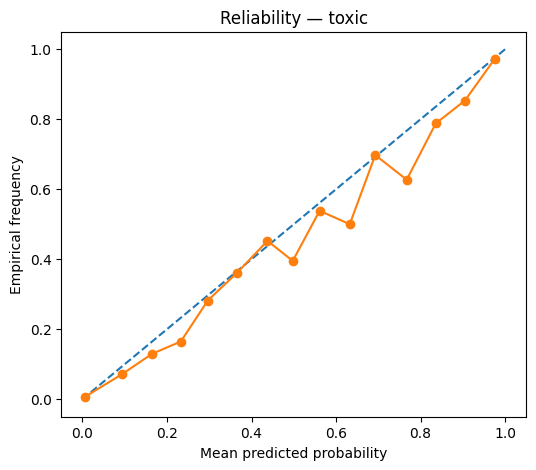

In [28]:
import matplotlib.pyplot as plt

# Brier score (lower = better); do per label
brier = {lab: float(np.mean((probs[:,i] - labels[:,i])**2)) for i, lab in enumerate(LABELS)}
print("Brier per label:", brier)
print("Brier macro mean:", float(np.mean(list(brier.values()))))

# Reliability diagram (per label)
def reliability(points=10):
    bins = np.linspace(0,1,points+1)
    out = {}
    for i, lab in enumerate(LABELS):
        p = probs[:,i]; y = labels[:,i]
        bin_acc, bin_conf, bin_n = [], [], []
        for b0, b1 in zip(bins[:-1], bins[1:]):
            m = (p>=b0) & (p<b1)
            if m.sum()==0:
                bin_acc.append(np.nan); bin_conf.append((b0+b1)/2); bin_n.append(0)
            else:
                bin_acc.append(float(y[m].mean()))
                bin_conf.append(float(p[m].mean()))
                bin_n.append(int(m.sum()))
        out[lab] = (np.array(bin_conf), np.array(bin_acc), np.array(bin_n))
    return out

rel = reliability(points=15)
plt.figure(figsize=(6,5))
lab0 = LABELS[0]
x,y,n = rel[lab0]
mask = ~np.isnan(y)
plt.plot([0,1],[0,1], linestyle="--")
plt.plot(x[mask], y[mask], marker="o")
plt.xlabel("Mean predicted probability")
plt.ylabel("Empirical frequency")
plt.title(f"Reliability — {lab0}")
plt.show()


In [29]:
def confusion(y, yhat):
    tp = int(((y==1)&(yhat==1)).sum())
    fp = int(((y==0)&(yhat==1)).sum())
    fn = int(((y==1)&(yhat==0)).sum())
    tn = int(((y==0)&(yhat==0)).sum())
    return {"TP":tp,"FP":fp,"FN":fn,"TN":tn}

for i, lab in enumerate(LABELS):
    cm = confusion(labels[:,i].astype(int), pred01_tuned[:,i].astype(int))
    print(lab, cm)


toxic {'TP': 647, 'FP': 168, 'FN': 126, 'TN': 7038}
severe_toxic {'TP': 53, 'FP': 72, 'FN': 23, 'TN': 7831}
obscene {'TP': 368, 'FP': 86, 'FN': 68, 'TN': 7457}
threat {'TP': 6, 'FP': 32, 'FN': 9, 'TN': 7932}
insult {'TP': 325, 'FP': 127, 'FN': 80, 'TN': 7447}
identity_hate {'TP': 31, 'FP': 68, 'FN': 36, 'TN': 7844}


In [30]:
rng = np.random.default_rng(123)
B = 1000
idx = np.arange(N)
f1s = []
for _ in range(B):
    s = rng.choice(idx, size=N, replace=True)
    f1,_macro,_ = f1_micro_macro(labels[s].astype(int), pred01_tuned[s].astype(int))
    f1s.append(f1)
lo, hi = np.percentile(f1s, [2.5, 97.5])
print(f"micro-F1 tuned: {f1_micro_tuned:.4f} (95% CI {lo:.4f}–{hi:.4f})")


micro-F1 tuned: 0.7617 (95% CI 0.7453–0.7780)


In [31]:
def top_examples(label_idx, k=5):
    # margin = distance from threshold; helpful to see close calls
    thr = thr_vec[label_idx]
    p = probs[:,label_idx]
    y = labels[:,label_idx].astype(int)
    # False positives (pred=1, true=0)
    fp_idx = np.where((p>=thr) & (y==0))[0]
    # False negatives (pred=0, true=1)
    fn_idx = np.where((p<thr) & (y==1))[0]

    fps = sorted(fp_idx, key=lambda i: -(p[i]-thr))[:k]
    fns = sorted(fn_idx, key=lambda i: -(thr-p[i]))[:k]
    return fps, fns

for j, lab in enumerate(LABELS):
    fps, fns = top_examples(j, k=3)
    print(f"\n=== {lab} — Top FP ===")
    for i in fps:
        print(f"p={probs[i,j]:.2f} | text={raw_texts[i][:140]}")
    print(f"=== {lab} — Top FN ===")
    for i in fns:
        print(f"p={probs[i,j]:.2f} | text={raw_texts[i][:140]}")



=== toxic — Top FP ===
p=0.98 | text=as for the ' blethering scot ' shite you can gtf. you support york shitty.
p=0.97 | text=space after period you bucket head. suck to much carbon monoxide? 207. 69. 139. 142
p=0.97 | text=" well, why didn ' t you point this out in the first place instead of acting like a nutcase and telling me i ' m " " censoring " " things? s
=== toxic — Top FN ===
p=0.00 | text=" : it is neither more historically correct, nor more professional. scholars routinely use the term " " nazi " ". you cite the encyclopedia 
p=0.01 | text=middle finger at the april 10 edition of raw, chris mordetsky was about to give the master lock on carlito but i think he stuck his middle f
p=0.01 | text=upskirting i enjoy looking up women ' s skirts.

=== severe_toxic — Top FP ===
p=0.65 | text=go fuck yourself you fucking dick go rot in hell piece of crap your mother is a whore
p=0.65 | text=go fuck yourself you mother fucking cunt.
p=0.64 | text=prepare you are the biggest cock sucki

In [32]:
lens = np.array([len(t.split()) for t in raw_texts])
bins = [0, 5, 15, 40, 1_000]
names = ["≤5", "6–15", "16–40", "41+"]

for b0,b1,name in zip(bins[:-1], bins[1:], names):
    m = (lens> b0) & (lens<= b1)
    if m.sum()==0: continue
    f1_mi, f1_ma, _ = f1_micro_macro(labels[m].astype(int), pred01_tuned[m].astype(int))
    print(f"{name:>6} words | n={int(m.sum()):>5} | micro-F1={f1_mi:.4f} | macro-F1={f1_ma:.4f}")


    ≤5 words | n=  198 | micro-F1=0.8288 | macro-F1=0.5816
  6–15 words | n= 1365 | micro-F1=0.7736 | macro-F1=0.6050
 16–40 words | n= 2388 | micro-F1=0.7988 | macro-F1=0.5978
   41+ words | n= 4028 | micro-F1=0.6889 | macro-F1=0.5492


In [33]:
import json, os, datetime as dt

OUT_ADAPTER = "/content/toxic_lora"
os.makedirs(OUT_ADAPTER, exist_ok=True)

with open(f"{OUT_ADAPTER}/thresholds.json","w") as f:
    json.dump({"thresholds": {k: float(v) for k,v in zip(LABELS, thr_vec)}}, f)

report = [
    f"# Eval summary — {dt.datetime.utcnow().strftime('%Y-%m-%d %H:%M UTC')}",
    f"- N val: {N}",
    f"- Prevalence: { {k: round(float(v),4) for k,v in zip(LABELS, prev)} }",
    f"- AUPRC: { {k: round(auprc[k],4) for k in LABELS} }",
    f"- F1 micro (0.5): {round(f1_micro,4)} | macro (0.5): {round(f1_macro,4)}",
    f"- F1 micro (tuned): {round(f1_micro_tuned,4)} | macro (tuned): {round(f1_macro_tuned,4)}",
    f"- Tuned thresholds: { {k: float(v) for k,v in zip(LABELS, thr_vec)} }",
]
open("/content/eval_summary.md","w").write("\n".join(report))
print("Wrote /content/eval_summary.md and thresholds.json")


Wrote /content/eval_summary.md and thresholds.json


/tmp/ipython-input-3500878392.py:10: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  f"# Eval summary — {dt.datetime.utcnow().strftime('%Y-%m-%d %H:%M UTC')}",


Validation examples: 7979, labels: 6 -> ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
         toxic: TN=  7038  FP=   168  FN=   126  TP=   647
  severe_toxic: TN=  7831  FP=    72  FN=    23  TP=    53
       obscene: TN=  7457  FP=    86  FN=    68  TP=   368
        threat: TN=  7932  FP=    32  FN=     9  TP=     6
        insult: TN=  7447  FP=   127  FN=    80  TP=   325
 identity_hate: TN=  7844  FP=    68  FN=    36  TP=    31


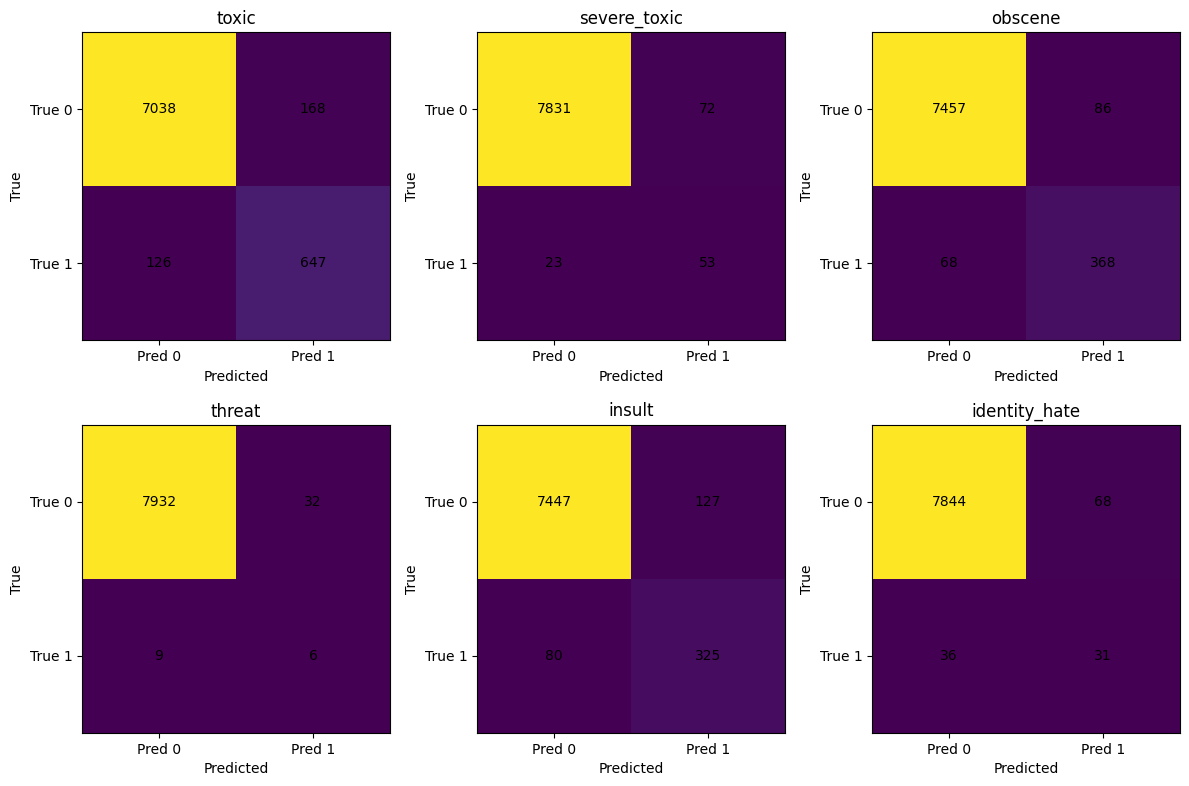

Saved: /content/confusion_per_label.png

Micro-aggregated CM (all labels flattened):
TN=45549  FP=553  FN=342  TP=1430


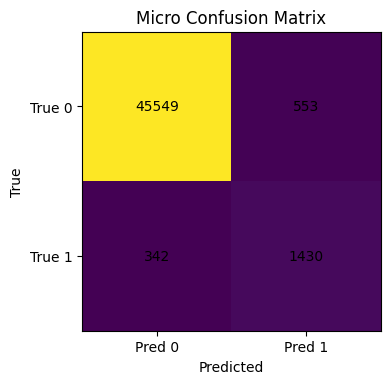

Saved: /content/confusion_micro.png


<Figure size 640x480 with 0 Axes>

In [34]:
# === Confusion Matrices for multi-label toxicity (validation set) ===
# - Per-label 2x2 confusion matrices (TN, FP / FN, TP)
# - One micro-aggregated confusion matrix across all labels
# - Saves PNGs to /content/

import os, json, numpy as np, torch
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# ---- Fallbacks if notebook vars aren't in memory ----
ADAPTER_DIR = "/content/toxic_lora"
def _device():
    return torch.device("cuda" if torch.cuda.is_available() else "cpu")

need_collect = False
if 'model' not in globals() or 'tok' not in globals() or 'valid_dl' not in globals():
    # Try to reload the LoRA model/adapter to compute logits on valid_dl-like data
    # (If you truly don't have valid_dl, you can't draw a confusion matrix without labels.)
    raise RuntimeError("Need model/tok/valid_dl in memory to compute confusion matrices.")

# Labels list
if 'LABELS' not in globals():
    labels_path = os.path.join(ADAPTER_DIR, "labels.json")
    assert os.path.exists(labels_path), "LABELS missing and no labels.json found."
    LABELS = json.load(open(labels_path))["labels"]

# Thresholds (optional)
thr = {k: 0.5 for k in LABELS}
thr_path = os.path.join(ADAPTER_DIR, "thresholds.json")
if os.path.exists(thr_path):
    try:
        thr = json.load(open(thr_path))["thresholds"]
    except Exception:
        pass
thr_vec = np.array([thr[k] for k in LABELS], dtype=np.float32)

# ---- Collect logits & labels from your validation DataLoader ----
model.eval()
dev = next(model.parameters()).device
all_logits, all_labels = [], []
with torch.no_grad():
    for batch in valid_dl:
        y = batch["labels"].numpy()
        b = {k: v.to(dev) for k, v in batch.items() if k != "labels"}
        lg = model(**b).logits.detach().cpu().numpy()
        all_logits.append(lg); all_labels.append(y)

logits = np.concatenate(all_logits, axis=0)           # (N, C)
labels = np.concatenate(all_labels, axis=0).astype(int)  # (N, C)
probs  = 1.0 / (1.0 + np.exp(-logits))
preds  = (probs >= thr_vec[None, :]).astype(int)

N, C = labels.shape
print(f"Validation examples: {N}, labels: {C} -> {LABELS}")

# ---- Per-label confusion matrices ----
cms = []
for i, lab in enumerate(LABELS):
    cm = confusion_matrix(labels[:, i], preds[:, i], labels=[0,1])
    # sklearn order: [[TN, FP],[FN, TP]]
    cms.append(cm)
    tn, fp, fn, tp = cm.ravel()
    print(f"{lab:>14}: TN={tn:6d}  FP={fp:6d}  FN={fn:6d}  TP={tp:6d}")

# ---- Plot per-label confusion matrices in a grid ----
import math
cols = 3
rows = math.ceil(C / cols)
fig, axes = plt.subplots(rows, cols, figsize=(cols*4, rows*4))
if rows == 1 and cols == 1:
    axes = np.array([[axes]])
elif rows == 1:
    axes = np.array([axes])

for i, lab in enumerate(LABELS):
    r, c = divmod(i, cols)
    ax = axes[r, c]
    cm = cms[i]
    im = ax.imshow(cm, interpolation="nearest")
    ax.set_title(lab)
    # annotate
    for (rr, cc), val in np.ndenumerate(cm):
        ax.text(cc, rr, str(val), ha="center", va="center")
    ax.set_xticks([0,1]); ax.set_xticklabels(["Pred 0","Pred 1"])
    ax.set_yticks([0,1]); ax.set_yticklabels(["True 0","True 1"])
    ax.set_xlabel("Predicted"); ax.set_ylabel("True")

# hide any empty subplots
for j in range(C, rows*cols):
    r, c = divmod(j, cols)
    axes[r, c].axis("off")

fig.tight_layout()
plt.show()
fig.savefig("/content/confusion_per_label.png", dpi=150)
print("Saved: /content/confusion_per_label.png")

# ---- Micro-aggregated confusion matrix (flatten across labels) ----
y_true_flat = labels.reshape(-1)
y_pred_flat = preds.reshape(-1)
cm_micro = confusion_matrix(y_true_flat, y_pred_flat, labels=[0,1])
print("\nMicro-aggregated CM (all labels flattened):")
tn, fp, fn, tp = cm_micro.ravel()
print(f"TN={tn}  FP={fp}  FN={fn}  TP={tp}")

plt.figure(figsize=(4,4))
im = plt.imshow(cm_micro, interpolation="nearest")
for (rr, cc), val in np.ndenumerate(cm_micro):
    plt.text(cc, rr, str(val), ha="center", va="center")
plt.xticks([0,1], ["Pred 0","Pred 1"])
plt.yticks([0,1], ["True 0","True 1"])
plt.xlabel("Predicted"); plt.ylabel("True"); plt.title("Micro Confusion Matrix")
plt.tight_layout()
plt.show()
plt.savefig("/content/confusion_micro.png", dpi=150)
print("Saved: /content/confusion_micro.png")
